<h1 style="text-align: center;">From Raw Data to Insights: Building a Lake House with Hudi and Star Schema Modeling</h1>





### What is Lake House Architecture?
* Lake House Architecture is a modern data storage architecture that combines the best of both data warehouse and data lake technologies. It allows organizations to store structured and unstructured data together in a single location, providing a unified view of data for analysis and reporting. With Lake House Architecture, data can be stored in a cost-effective manner and can be easily accessed and processed by data analysts and data scientists.



### What is a Transactional Data Lake?

* A Transactional Data Lake is a type of data lake that allows for both batch and real-time data processing, making it ideal for use in modern data processing and analytics. It provides transactional capabilities for data operations such as insert, update, and delete, ensuring that data is always up-to-date and accurate. This makes it possible for organizations to have a single source of truth for all their data, reducing data silos and improving data consistency and accuracy.




### Advantages of Star Schema with Lake House Architecture and Hudi
* The Star Schema is a popular design pattern for data warehousing that works well with Lake House Architecture and Hudi. The Star Schema organizes data into a central fact table and related dimension tables, providing a simple and intuitive structure for querying data. Using the Star Schema with Lake House Architecture and Hudi offers several advantages, including:

* Improved query performance: The Star Schema's simplified structure allows for faster and more efficient querying of large data sets, making it easier for analysts to extract insights from data.
* Easier to maintain: The Star Schema is easy to maintain and update, making it ideal for organizations that need to make frequent changes to their data models.

* Scalability: Lake House Architecture and Hudi allow for horizontal scaling, enabling organizations to easily scale up or down their data processing and storage needs as their business grows.



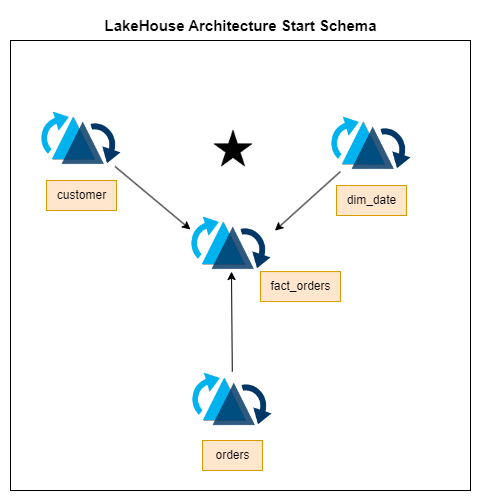

# Step 1: Define imports 

In [1]:
try:
    import os
    import sys
    import uuid
    import random
    
    import pyspark
    from pyspark.sql import SparkSession
    from pyspark import SparkConf, SparkContext
    from pyspark.sql.functions import col, asc, desc, to_timestamp, monotonically_increasing_id, to_date, when, udf
    from pyspark.sql.types import *
    from functools import reduce
    from faker import Faker
    import pandas as pd
    
    import boto3
    import json
    from datetime import datetime, date, timedelta

    from pyspark.sql.functions import year, quarter, month, dayofmonth, weekofyear
    from pyspark.sql import functions as F

except Exception as e:
    print(e)


# Step 2: Define Spark Session 

In [23]:
SUBMIT_ARGS = "--packages org.apache.hudi:hudi-spark3.3-bundle_2.12:0.12.1 pyspark-shell"

os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

bucket = 'delta-streamer-demo-hudi'
os.environ['AWS_REGION'] = 'us-east-1'
bucket = 'delta-streamer-demo-hudi'
os.environ['AWS_ACCESS_KEY'] = 'XXXXX'
os.environ['AWS_SECRET_KEY'] = 'XXXXXXXXXS'
os.environ['AWS_REGION'] = 'us-east-1'


spark = SparkSession.builder \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.sql.extensions', 'org.apache.spark.sql.hudi.HoodieSparkSessionExtension') \
    .config('className', 'org.apache.hudi') \
    .config('spark.sql.hive.convertMetastoreParquet', 'false') \
    .getOrCreate()

spark

# Step 3: Data Generator Class

In [7]:
global faker
faker = Faker()

import uuid

def get_customer_data(total_customers=2):
    customers_array = []
    for i in range(0, total_customers):
        customer_data = {
            "customer_id": str(uuid.uuid4()),
            "name": faker.name(),
            "state": faker.state(),
            "city": faker.city(),
            "email": faker.email(),
            "created_at": datetime.now().isoformat().__str__(),
            "address":faker.address()
        }
        customers_array.append(customer_data)
    return customers_array

def get_orders_data(customer_ids, order_data_sample_size=3):
    orders_array = []
    for i in range(0, order_data_sample_size):
        try:
            order_id = uuid.uuid4().__str__()
            customer_id= random.choice(customer_ids)
            order_data = {
                "order_id": order_id,
                "name": faker.text(max_nb_chars=20),
                "order_value": random.randint(10, 1000).__str__(),
                "priority": random.choice(["LOW", "MEDIUM", "HIGH"]),
                "order_date": faker.date_between(start_date='-30d', end_date='today').strftime('%Y-%m-%d'),
                "customer_id": customer_id
            }
            orders_array.append(order_data)
        except Exception as e:
            print(e)
    return orders_array

# Step 4: Method to Upsert into Hudi tables 

In [8]:
def upsert_hudi_table(
                        db_name,
                      table_name,
                      record_id,
                      precomb_key,
                      spark_df,
                      table_type='COPY_ON_WRITE',
                      method='upsert',
                      ):

    path = f"file:///C:/tmp/{db_name}/{table_name}"
    print("path", path, end="\n")
    hudi_options = {
        'hoodie.table.name': table_name,
        'hoodie.datasource.write.table.type': table_type,
        'hoodie.datasource.write.recordkey.field': record_id,
        'hoodie.datasource.write.table.name': table_name,
        'hoodie.datasource.write.operation': method,
        'hoodie.datasource.write.precombine.field': precomb_key,
    }
    spark_df.write.format("hudi"). \
        options(**hudi_options). \
        mode("append"). \
        save(path)

### Sample Preview of Customer data

In [9]:
global total_customers, order_data_sample_size

total_customers = 2
order_data_sample_size = 3

customer_data  = get_customer_data(total_customers=total_customers)
spark_df_customers = spark.createDataFrame(data=[tuple(i.values()) for i in customer_data],
                                           schema=list(customer_data[0].keys()))
spark_df_customers.show()

+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+
|         customer_id|          name|        state|            city|               email|          created_at|             address|
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+
|47c5083d-1b5e-493...|    Lee Rivera|      Florida|       Juanhaven|adammcbride@examp...|2023-04-27T07:45:...|394 Matthews Lodg...|
|f4418467-19e8-4d6...|Maria Peterson|New Hampshire|New Jeanettetown|cummingsronald@ex...|2023-04-27T07:45:...|264 Bonilla Valle...|
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+



### Sample preview for Order Data

In [10]:
order_data  = get_orders_data(order_data_sample_size=order_data_sample_size, customer_ids=[i.get("customer_id")for i in customer_data])

spark_df_orders = spark.createDataFrame(data=[tuple(i.values()) for i in order_data],
                                        schema=list(order_data[0].keys()))

spark_df_orders.show()

+--------------------+------------------+-----------+--------+----------+--------------------+
|            order_id|              name|order_value|priority|order_date|         customer_id|
+--------------------+------------------+-----------+--------+----------+--------------------+
|c89289ef-2239-49d...|Most type pattern.|        257|    HIGH|2023-04-06|47c5083d-1b5e-493...|
|e13b2e05-2182-4ce...|  Figure suddenly.|        378|    HIGH|2023-04-08|47c5083d-1b5e-493...|
|c2f57fa6-f3cb-4a4...| Positive through.|        699|  MEDIUM|2023-04-06|47c5083d-1b5e-493...|
+--------------------+------------------+-----------+--------+----------+--------------------+



## UPSERT into Hudi tables 

#### Upserting into Customer Hudi Tables 

In [11]:
upsert_hudi_table(
    db_name='hudidb',
    table_name='customers',
    record_id='customer_id',
    precomb_key='created_at',
    spark_df=spark_df_customers,
    table_type='COPY_ON_WRITE',
    method='upsert',
)

path file:///C:/tmp/hudidb/customers


#### Upserting into Order Hudi Tables # 

In [12]:
upsert_hudi_table(
    db_name='hudidb',
    table_name='orders',
    record_id='order_id',
    precomb_key='order_date',
    spark_df=spark_df_orders,
    table_type='COPY_ON_WRITE',
    method='upsert',
)

path file:///C:/tmp/hudidb/orders


# Bulding Hudi Date Dimensions

In [13]:
min_date = '2020-01-01'
max_date = '2025-01-01'

date_range = pd.date_range(start=min_date, end=max_date)
date_data = [(int(day.strftime('%Y%m%d')), day.year, day.month, day.day, str((day.month-1)//3+1), 
              day.strftime('%A'), day.weekday()) for day in date_range]
date_schema = ['date_key', 'year', 'month', 'day', 'quarter', 'weekday', 'weekday_number']
date_dim_df = spark.createDataFrame(date_data, schema=date_schema)

####  Upsert date dimension into Hudi 

In [14]:
upsert_hudi_table(
    db_name='hudidb',
    table_name='dim_date',
    record_id='date_key',
    precomb_key='date_key',
    spark_df=date_dim_df,
    table_type='COPY_ON_WRITE',
    method='upsert',
)

path file:///C:/tmp/hudidb/dim_date


# To avoid performing a full table scan while inserting into the Fact table, we will use an incremental pull strategy.
 
* Incremnetally Pull from order tables and then we load fact tables 
* Template 
* Link https://github.com/soumilshah1995/An-easy-to-use-Python-utility-class-for-accessing-incremental-data-from-Hudi-Data-Lakes

In [22]:
import ast

try:
    import sys
    import os
    import datetime
    from ast import literal_eval
    import re
    import boto3
    from pyspark.sql import SparkSession
    from pyspark import SparkConf, SparkContext
    import json
    from dataclasses import dataclass
    from datetime import datetime
except Exception as e:
    pass


class AWSS3(object):
    """Helper class to which add functionality on top of boto3 """

    def __init__(self, bucket):

        self.BucketName = bucket
        self.client = boto3.client("s3",
                            aws_access_key_id=os.getenv("AWS_ACCESS_KEY"),
                            aws_secret_access_key=os.getenv("AWS_SECRET_KEY"),
                            region_name=os.getenv("AWS_REGION")
                                   )

    def put_files(self, Response=None, Key=None):
        """
        Put the File on S3
        :return: Bool
        """
        try:
            response = self.client.put_object(
                Body=Response, Bucket=self.BucketName, Key=Key
            )
            return "ok"
        except Exception as e:
            raise Exception("Error : {} ".format(e))

    def item_exists(self, Key):
        """Given key check if the items exists on AWS S3 """
        try:
            response_new = self.client.get_object(Bucket=self.BucketName, Key=str(Key))
            return True
        except Exception as e:
            return False

    def get_item(self, Key):

        """Gets the Bytes Data from AWS S3 """

        try:
            response_new = self.client.get_object(Bucket=self.BucketName, Key=str(Key))
            return response_new["Body"].read()

        except Exception as e:
            print("Error :{}".format(e))
            return False

    def find_one_update(self, data=None, key=None):

        """
        This checks if Key is on S3 if it is return the data from s3
        else store on s3 and return it
        """

        flag = self.item_exists(Key=key)

        if flag:
            data = self.get_item(Key=key)
            return data

        else:
            self.put_files(Key=key, Response=data)
            return data

    def delete_object(self, Key):

        response = self.client.delete_object(Bucket=self.BucketName, Key=Key, )
        return response

    def get_all_keys(self, Prefix=""):

        """
        :param Prefix: Prefix string
        :return: Keys List
        """
        try:
            paginator = self.client.get_paginator("list_objects_v2")
            pages = paginator.paginate(Bucket=self.BucketName, Prefix=Prefix)

            tmp = []

            for page in pages:
                for obj in page["Contents"]:
                    tmp.append(obj["Key"])

            return tmp
        except Exception as e:
            return []

    def print_tree(self):
        keys = self.get_all_keys()
        for key in keys:
            print(key)
        return None

    def find_one_similar_key(self, searchTerm=""):
        keys = self.get_all_keys()
        return [key for key in keys if re.search(searchTerm, key)]

    def __repr__(self):
        return "AWS S3 Helper class "


@dataclass
class HUDISettings:
    """Class for keeping track of an item in inventory."""

    table_name: str
    path: str


class HUDIIncrementalReader(AWSS3):
    def __init__(self, bucket, hudi_settings, spark_session):
        AWSS3.__init__(self, bucket=bucket)
        if type(hudi_settings).__name__ != "HUDISettings": raise Exception("please pass correct settings ")
        self.hudi_settings = hudi_settings
        self.spark = spark_session

    def __check_meta_data_file(self):
        """
        check if metadata for table exists
        :return: Bool
        """
        file_name = f"metadata/{self.hudi_settings.table_name}.json"
        return self.item_exists(Key=file_name)

    def __read_meta_data(self):
        file_name = f"metadata/{self.hudi_settings.table_name}.json"

        return ast.literal_eval(self.get_item(Key=file_name).decode("utf-8"))

    def __push_meta_data(self, json_data):
        file_name = f"metadata/{self.hudi_settings.table_name}.json"
        self.put_files(
            Key=file_name, Response=json.dumps(json_data)
        )
    def clean_check_point(self):
        file_name = f"metadata/{self.hudi_settings.table_name}.json"
        self.delete_object(Key=file_name)

    def __get_begin_commit(self):
        self.spark.read.format("hudi").load(self.hudi_settings.path).createOrReplaceTempView("hudi_snapshot")
        commits = list(map(lambda row: row[0], self.spark.sql(
            "select distinct(_hoodie_commit_time) as commitTime from  hudi_snapshot order by commitTime asc").limit(
            50).collect()))

        """begin from start """
        begin_time = int(commits[0]) - 1
        return begin_time

    def __read_inc_data(self, commit_time):
        incremental_read_options = {
            'hoodie.datasource.query.type': 'incremental',
            'hoodie.datasource.read.begin.instanttime': commit_time,
        }
        incremental_df = self.spark.read.format("hudi").options(**incremental_read_options).load(
            self.hudi_settings.path).createOrReplaceTempView("hudi_incremental")

        df = self.spark.sql("select * from  hudi_incremental")

        return df

    def __get_last_commit(self):
        commits = list(map(lambda row: row[0], self.spark.sql(
            "select distinct(_hoodie_commit_time) as commitTime from  hudi_incremental order by commitTime asc").limit(
            50).collect()))
        last_commit = commits[len(commits) - 1]
        return last_commit

    def __run(self):
        """Check the metadata file"""
        flag = self.__check_meta_data_file()
        """if metadata files exists load the last commit and start inc loading from that commit """
        if flag:
            meta_data = json.loads(self.__read_meta_data())
            print(f"""
            ******************LOGS******************
            meta_data {meta_data}
            last_processed_commit : {meta_data.get("last_processed_commit")}
            ***************************************
            """)

            read_commit = str(meta_data.get("last_processed_commit"))
            df = self.__read_inc_data(commit_time=read_commit)

            """if there is no INC data then it return Empty DF """
            if not df.rdd.isEmpty():
                last_commit = self.__get_last_commit()
                self.__push_meta_data(json_data=json.dumps({
                    "last_processed_commit": last_commit,
                    "table_name": self.hudi_settings.table_name,
                    "path": self.hudi_settings.path,
                    "inserted_time": datetime.now().__str__(),

                }))
                return df
            else:
                return df

        else:

            """Metadata files does not exists meaning we need to create  metadata file on S3 and start reading from begining commit"""

            read_commit = self.__get_begin_commit()

            df = self.__read_inc_data(commit_time=read_commit)
            last_commit = self.__get_last_commit()

            self.__push_meta_data(json_data=json.dumps({
                "last_processed_commit": last_commit,
                "table_name": self.hudi_settings.table_name,
                "path": self.hudi_settings.path,
                "inserted_time": datetime.now().__str__(),

            }))

            return df

    def read(self):
        """
        reads INC data and return Spark Df
        :return:
        """

        return self.__run()


### Hudi Paths

In [24]:
customers = "file:///C:/tmp/hudidb/customers"
order_hudi = "file:///C:/tmp/hudidb/orders"
date_dim = 'file:///C:/tmp/hudidb/dim_date'

#### Define Incremnteal Pull instance 

In [31]:
helper.clean_check_point()

#### INC pulling order 

In [32]:
helper = HUDIIncrementalReader(
    bucket=bucket,
    hudi_settings=HUDISettings(
    table_name='orders',
    path=order_hudi),
    spark_session=spark
)

view_name_orders = "orders"
df = helper.read()
df.createOrReplaceTempView(view_name_orders)

### Creating Hudi Snapshots

In [33]:
spark.read.format("hudi").load(customers).createOrReplaceTempView("customers")
spark.read.format("hudi").load(date_dim).createOrReplaceTempView("date_dim")

### Preview of Hudi Dataset
* orders
* customers
* date dimensions

In [34]:
from pyspark.sql.functions import col

# Columns to exclude
exclude_cols = ['_hoodie_commit_time',
                '_hoodie_commit_seqno',
                '_hoodie_record_key',
                '_hoodie_partition_path',
                '_hoodie_file_name']

# Define function to exclude columns and display DF in tabular format
def display_df(df):
    for col_name in exclude_cols:
        df = df.drop(col_name)
    df.show()
    

# Display DataFrames
display_df(spark.sql("SELECT * FROM customers"))
display_df(spark.sql("SELECT * FROM orders"))
display_df(spark.sql("SELECT * FROM date_dim"))


+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+
|         customer_id|          name|        state|            city|               email|          created_at|             address|
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+
|47c5083d-1b5e-493...|    Lee Rivera|      Florida|       Juanhaven|adammcbride@examp...|2023-04-27T07:45:...|394 Matthews Lodg...|
|f4418467-19e8-4d6...|Maria Peterson|New Hampshire|New Jeanettetown|cummingsronald@ex...|2023-04-27T07:45:...|264 Bonilla Valle...|
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+

+--------------------+------------------+-----------+--------+----------+--------------------+
|            order_id|              name|order_value|priority|order_date|         customer_id|
+----------------

# Creating Hudi fact table

In [35]:
order_fact_df = spark.sql("""
SELECT
    o.order_id,
    c.customer_id,
    o.order_value,
    o.priority,
    d.date_key
FROM
    orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN (
        SELECT date_key, to_date(date_key, 'yyyyMMdd') as date
        FROM date_dim
    ) d ON to_date(o.order_date, 'yyyy-MM-dd') = d.date
    
""")

# Writeing into Hudi Fact table 

In [36]:
upsert_hudi_table(
    db_name='hudidb',
    table_name='orders_fact',
    record_id='order_id,customer_id',
    precomb_key='order_id',
    spark_df=order_fact_df,
    table_type='COPY_ON_WRITE',
    method='upsert',
)

path file:///C:/tmp/hudidb/orders_fact


# Reading from Fact Table

In [37]:
customers = "file:///C:/tmp/hudidb/customers"
order_hudi = "file:///C:/tmp/hudidb/orders"
date_dim = 'file:///C:/tmp/hudidb/dim_date'
order_faact = "file:///C:/tmp/hudidb/orders_fact"

spark.read.format("hudi").load(order_faact).createOrReplaceTempView("orders_fact")


In [38]:
from pyspark.sql.functions import col

# Columns to exclude
exclude_cols = ['_hoodie_commit_time',
                '_hoodie_commit_seqno',
                '_hoodie_record_key',
                '_hoodie_partition_path',
                '_hoodie_file_name']

# Define function to exclude columns and display DF in tabular format
def display_df(df):
    for col_name in exclude_cols:
        df = df.drop(col_name)
    df.show()
    

# Display DataFrames
print("customers table", end="\n")
display_df(spark.sql("SELECT * FROM customers"))

print("orders table", end="\n")
display_df(spark.sql("SELECT * FROM orders"))

print("Date Dimension ", end="\n")
display_df(spark.sql("SELECT * FROM date_dim"))

print("Fact table", end="\n")
display_df(spark.sql("SELECT * FROM orders_fact"))

customers table
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+
|         customer_id|          name|        state|            city|               email|          created_at|             address|
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+
|47c5083d-1b5e-493...|    Lee Rivera|      Florida|       Juanhaven|adammcbride@examp...|2023-04-27T07:45:...|394 Matthews Lodg...|
|f4418467-19e8-4d6...|Maria Peterson|New Hampshire|New Jeanettetown|cummingsronald@ex...|2023-04-27T07:45:...|264 Bonilla Valle...|
+--------------------+--------------+-------------+----------------+--------------------+--------------------+--------------------+

orders table
+--------------------+------------------+-----------+--------+----------+--------------------+
|            order_id|              name|order_value|priority|order_date|         c

 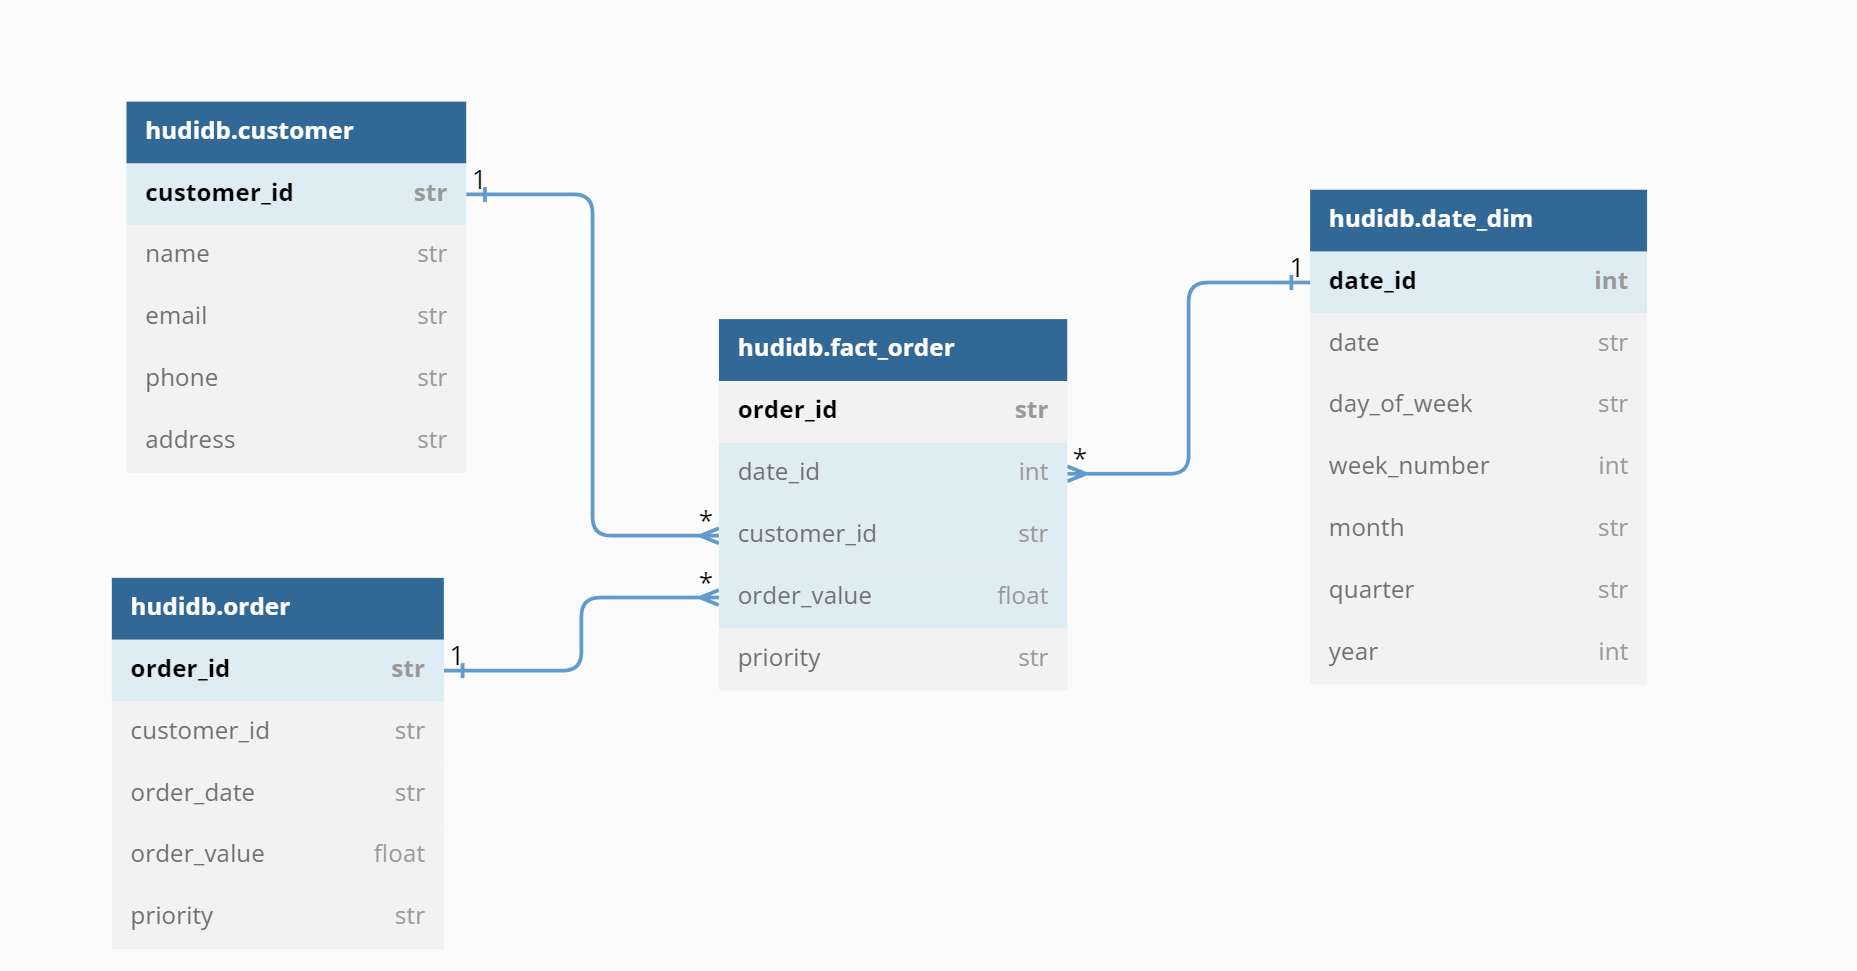

# Lets see if we run INC template i should not be getting data as i have alreaady processed it 

In [40]:
df = helper.read()
print(df.show())


            ******************LOGS******************
            meta_data {'last_processed_commit': '20230427074553782', 'table_name': 'orders', 'path': 'file:///C:/tmp/hudidb/orders', 'inserted_time': '2023-04-27 07:54:35.606910'}
            last_processed_commit : 20230427074553782
            ***************************************
            
+-------------------+--------------------+------------------+----------------------+-----------------+--------+----+-----------+--------+----------+-----------+
|_hoodie_commit_time|_hoodie_commit_seqno|_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name|order_id|name|order_value|priority|order_date|customer_id|
+-------------------+--------------------+------------------+----------------------+-----------------+--------+----+-----------+--------+----------+-----------+
+-------------------+--------------------+------------------+----------------------+-----------------+--------+----+-----------+--------+----------+-----------+

No

### Perfect 

# Adding New data into order tables and inc pulling it and updating fact table

In [41]:
order_data  = get_orders_data(order_data_sample_size=order_data_sample_size, customer_ids=[i.get("customer_id")for i in customer_data])

spark_df_orders = spark.createDataFrame(data=[tuple(i.values()) for i in order_data],
                                        schema=list(order_data[0].keys()))

spark_df_orders.show()

upsert_hudi_table(
    db_name='hudidb',
    table_name='orders',
    record_id='order_id',
    precomb_key='order_date',
    spark_df=spark_df_orders,
    table_type='COPY_ON_WRITE',
    method='upsert',
)

+--------------------+-------------------+-----------+--------+----------+--------------------+
|            order_id|               name|order_value|priority|order_date|         customer_id|
+--------------------+-------------------+-----------+--------+----------+--------------------+
|fb59333f-fe42-436...|Like official soon.|        278|  MEDIUM|2023-04-01|f4418467-19e8-4d6...|
|db7ec827-fab5-4b1...|  Whose memory leg.|        343|  MEDIUM|2023-04-13|f4418467-19e8-4d6...|
|b186d414-4b73-4a4...| Few person notice.|        387|  MEDIUM|2023-04-16|47c5083d-1b5e-493...|
+--------------------+-------------------+-----------+--------+----------+--------------------+

path file:///C:/tmp/hudidb/orders


# Lets pull new Data and update into Fact table

In [42]:
view_name_orders = "orders"
df = helper.read()
df.createOrReplaceTempView(view_name_orders)
spark.read.format("hudi").load(customers).createOrReplaceTempView("customers")
spark.read.format("hudi").load(date_dim).createOrReplaceTempView("date_dim")

order_fact_df = spark.sql("""
SELECT
    o.order_id,
    c.customer_id,
    o.order_value,
    o.priority,
    d.date_key
FROM
    orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN (
        SELECT date_key, to_date(date_key, 'yyyyMMdd') as date
        FROM date_dim
    ) d ON to_date(o.order_date, 'yyyy-MM-dd') = d.date
    
""")
upsert_hudi_table(
    db_name='hudidb',
    table_name='orders_fact',
    record_id='order_id,customer_id',
    precomb_key='order_id',
    spark_df=order_fact_df,
    table_type='COPY_ON_WRITE',
    method='upsert',
)



            ******************LOGS******************
            meta_data {'last_processed_commit': '20230427074553782', 'table_name': 'orders', 'path': 'file:///C:/tmp/hudidb/orders', 'inserted_time': '2023-04-27 07:54:35.606910'}
            last_processed_commit : 20230427074553782
            ***************************************
            
path file:///C:/tmp/hudidb/orders_fact


# Reading from Fact Table

In [44]:
order_faact = "file:///C:/tmp/hudidb/orders_fact"

spark.read.format("hudi").load(order_faact).createOrReplaceTempView("orders_fact")

print("Fact table", end="\n")
display_df(spark.sql("SELECT * FROM orders_fact"))


Fact table
+--------------------+--------------------+-----------+--------+--------+
|            order_id|         customer_id|order_value|priority|date_key|
+--------------------+--------------------+-----------+--------+--------+
|c89289ef-2239-49d...|47c5083d-1b5e-493...|        257|    HIGH|20230406|
|e13b2e05-2182-4ce...|47c5083d-1b5e-493...|        378|    HIGH|20230408|
|c2f57fa6-f3cb-4a4...|47c5083d-1b5e-493...|        699|  MEDIUM|20230406|
|fb59333f-fe42-436...|f4418467-19e8-4d6...|        278|  MEDIUM|20230401|
|db7ec827-fab5-4b1...|f4418467-19e8-4d6...|        343|  MEDIUM|20230413|
|b186d414-4b73-4a4...|47c5083d-1b5e-493...|        387|  MEDIUM|20230416|
+--------------------+--------------------+-----------+--------+--------+



# Conclusion 
* In conclusion, Lake House Architecture and Hudi provide a flexible and powerful data storage and processing solution for modern businesses. The Star Schema design pattern enhances the benefits of these technologies, providing a simple and effective way to query and analyze large data sets.




